In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, mean_squared_error
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

warnings.filterwarnings("ignore")


In [5]:
def load_dataset(scaler="minmax", strategy="split"):
    """
    Carrega os datasets NSL-KDD com duas estratégias:
    - 'split': carrega apenas o arquivo de treino e faz split em treino e validação
    - 'merge': carrega treino e teste reais e faz codificação alinhada
    """
    assert scaler in ["minmax", "standard"], "Escala inválida"
    assert strategy in ["split", "merge"], "Estratégia deve ser 'split' ou 'merge'"
    
    base_path = f"../data/final/{scaler}"
    train_path = f"{base_path}/KDDTrain+_final_{scaler}.csv"
    test_path = f"{base_path}/KDDTest+_final_{scaler}.csv"

    if strategy == "split":
        df = pd.read_csv(train_path)
        print(f"[SPLIT] Escala usada: {scaler}")
        print("Dataset carregado:", df.shape)

        # Split em treino e validação
        df_train, df_test = train_test_split(
            df, test_size=0.2, random_state=1, stratify=df["attack_category"]
        )
        print("Train split:", df_train.shape)
        print("Validação split:", df_test.shape)

        return df_train.reset_index(drop=True), df_test.reset_index(drop=True)

    else:  # strategy == "merge"
        df_train = pd.read_csv(train_path)
        df_test = pd.read_csv(test_path)

        df_train["__origin__"] = "train"
        df_test["__origin__"] = "test"

        df_all = pd.concat([df_train, df_test], axis=0)

        origin = df_all["__origin__"]
        target = df_all["attack_category"]
        df_all = df_all.drop(columns=["__origin__", "attack_category"])

        df_all = pd.get_dummies(df_all)

        df_all["attack_category"] = target.values
        df_all["__origin__"] = origin.values

        df_train_final = df_all[df_all["__origin__"] == "train"].drop(columns="__origin__")
        df_test_final = df_all[df_all["__origin__"] == "test"].drop(columns="__origin__")

        print(f"[MERGE] Escala usada: {scaler}")
        print("Train final:", df_train_final.shape)
        print("Test final :", df_test_final.shape)

        return df_train_final.reset_index(drop=True), df_test_final.reset_index(drop=True)


In [6]:
# minmax or standard
# Estratégia de split (KDDTrain+ somente)

df_train, df_val = load_dataset("minmax", strategy="split")

X_train = df_train.drop(columns=["attack_category"])
y_train = df_train["attack_category"]

X_val = df_val.drop(columns=["attack_category"])
y_val = df_val["attack_category"]

# Estratégia para avaliação final real (KDDTrain+ e KDDTest+ juntos)
df_train_final, df_test_final = load_dataset("minmax", strategy="merge")

X_train_final = df_train_final.drop(columns=["attack_category"])
y_train_final = df_train_final["attack_category"]

X_test_final = df_test_final.drop(columns=["attack_category"])
y_test_final = df_test_final["attack_category"]

[SPLIT] Escala usada: minmax
Dataset carregado: (125973, 62)
Train split: (100778, 62)
Validação split: (25195, 62)
[MERGE] Escala usada: minmax
Train final: (125973, 64)
Test final : (22544, 64)


# 4. Random Forest

Esta seção explora o uso do algoritmo Random Forest para detecção de intrusões no dataset NSL-KDD. Serão realizados experimentos de tuning de hiperparâmetros, avaliação detalhada e análise de desempenho em diferentes cenários de validação.

## Hiperparâmetros e Estratégia de Tuning

O artigo original utilizou Random Forest com:
- `n_estimators = 100`
- `random_state = 1`

Outros hiperparâmetros não foram especificados. Para buscar melhor desempenho, será realizado tuning com `GridSearchCV`, testando:

- `n_estimators`: número de árvores na floresta.
- `max_depth`: profundidade máxima das árvores.
- `min_samples_split`: mínimo de amostras para dividir um nó.
- `min_samples_leaf`: mínimo de amostras em uma folha.
- `max_features`: fração de variáveis consideradas por divisão.
- `bootstrap`: amostragem com substituição.
- `class_weight`: balanceamento de classes.

O tuning será feito em múltiplas etapas, refinando progressivamente o espaço de busca.

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd
import time


def run_grid_search(X, y, param_grid, cv=3, scoring='f1_macro'):
    model = RandomForestClassifier(random_state=1, n_jobs=1)
    
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        verbose=2,
        n_jobs=-1,
        return_train_score=True
    )
    
    start = time.time()
    grid.fit(X, y)
    duration = time.time() - start

    # Convert results to DataFrame
    results_df = pd.DataFrame(grid.cv_results_)
    results_df = results_df.sort_values(by="mean_test_score", ascending=False)

    # Print best parameters
    print("\nMelhores parâmetros encontrados:")
    for k, v in grid.best_params_.items():
        print(f"  {k}: {v}")
    print(f"\nMelhor {scoring}: {grid.best_score_:.4f}")
    print(f"Tempo total: {duration:.2f} segundos")

    # Top 10 results
    display_columns = [
        'mean_test_score', 'mean_train_score', 'std_test_score'
    ] + [col for col in results_df.columns if col.startswith('param_')]

    print("\nTop 10 combinações:")
    display(results_df[display_columns].head(10))

    return grid, results_df


### Iteração 1 – Baseline com Variação Ampla

Primeira busca de hiperparâmetros, abrangendo valores típicos para os principais parâmetros. Objetivo: estabelecer um baseline inicial.

Parâmetros explorados:
- `n_estimators = [100, 200]`
- `max_depth = [None, 10, 30]`
- `min_samples_leaf = [1, 5]`
- `min_samples_split = [2, 5]`
- `class_weight = [None, 'balanced']`

In [5]:
param_grid_1 = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 30],
    'min_samples_leaf': [1, 5],
    'min_samples_split': [2, 5], # pode ser só 2
    'max_features': ['sqrt'],
    'class_weight': [None, 'balanced']
}

grid_1, results_1 = run_grid_search(X_train, y_train, param_grid_1)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  11.1s
[CV] END class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=  11.1s
[CV] END class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  11.2s
[CV] END class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  11.2s
[CV] END class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=  11.3s
[CV] END class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  11.5s
[CV] END class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_sampl

,mean_test_score,mean_train_score,std_test_score,param_class_weight,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators
16,0.935402,0.998776,0.006215,None,30,sqrt,1,2,100
0,0.935240,0.998776,0.005869,None,None,sqrt,1,2,100
31,0.934406,0.968021,0.011430,balanced,None,sqrt,5,5,200
29,0.934406,0.968021,0.011430,balanced,None,sqrt,5,2,200
45,0.934406,0.968021,0.011430,balanced,30,sqrt,5,2,200
47,0.934406,0.968021,0.011430,balanced,30,sqrt,5,5,200
17,0.933231,0.998776,0.008405,None,30,sqrt,1,2,200
26,0.932384,0.992656,0.009731,balanced,None,sqrt,1,5,100
42,0.932364,0.992650,0.009745,balanced,30,sqrt,1,5,100
18,0.932199,0.977050,0.008177,None,30,sqrt,1,5,100


### Iteração 2 – Refinamento: Mais Árvores e Profundidade

Expansão do grid para mais árvores e diferentes profundidades, além de testar diferentes estratégias para `max_features`.

Parâmetros explorados:
- `n_estimators = [200, 300, 400]`
- `max_depth = [20, 30, 40]`
- `max_features = ['sqrt', 'log2', 0.5]`

In [6]:
param_grid_2 = {
    'n_estimators': [200, 300, 400],
    'max_depth': [20, 30, 40],
    'max_features': ['sqrt', 'log2', 0.5],
    'min_samples_leaf': [1],  # fixado
    'min_samples_split': [5],  # fixado
    'class_weight': ['balanced']  # fixado
}
grid_2, results_2 = run_grid_search(X_train, y_train, param_grid_2)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  19.6s
[CV] END class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  19.6s
[CV] END class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  19.7s
[CV] END class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  21.5s
[CV] END class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  21.6s
[CV] END class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  21.7s
[CV] END class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf

,mean_test_score,mean_train_score,std_test_score,param_class_weight,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators
17,0.935061,0.994081,0.013710,balanced,30,0.5,1,5,400
26,0.935061,0.994144,0.013710,balanced,40,0.5,1,5,400
25,0.934777,0.994081,0.013655,balanced,40,0.5,1,5,300
16,0.934652,0.994081,0.013490,balanced,30,0.5,1,5,300
15,0.934545,0.995173,0.013927,balanced,30,0.5,1,5,200
24,0.934545,0.995236,0.013927,balanced,40,0.5,1,5,200
7,0.934112,0.989545,0.017625,balanced,20,0.5,1,5,300
3,0.933152,0.990774,0.006172,balanced,20,log2,1,5,200
8,0.931896,0.989771,0.013080,balanced,20,0.5,1,5,400
5,0.931527,0.990768,0.015983,balanced,20,log2,1,5,400


### Iteração 3 – Avaliação de Split Mínimo

Testa o impacto do parâmetro `min_samples_split` em conjunto com diferentes quantidades de árvores e profundidades.

Parâmetros explorados:
- `n_estimators = [100, 400, 500]`
- `max_depth = [30, 40]`
- `min_samples_split = [2, 5]`

In [7]:
param_grid_3 = {
    'n_estimators': [100, 400, 500],
    'max_depth': [30, 40],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1],
    'min_samples_split': [2,5],
    'class_weight': ['balanced']
}


grid_3, results_3 = run_grid_search(X_train, y_train, param_grid_3)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  10.9s
[CV] END class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  10.9s
[CV] END class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  11.2s
[CV] END class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  11.3s
[CV] END class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  11.3s
[CV] END class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  11.3s
[CV] END class_weight=balanced, max_depth=40, max_features=sqrt, min_samples_leaf

,mean_test_score,mean_train_score,std_test_score,param_class_weight,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators
9,0.932384,0.992656,0.009731,balanced,40,sqrt,1,5,100
3,0.932364,0.992650,0.009745,balanced,30,sqrt,1,5,100
1,0.931123,0.998818,0.011986,balanced,30,sqrt,1,2,400
11,0.930557,0.992728,0.012040,balanced,40,sqrt,1,5,500
5,0.930545,0.992728,0.012058,balanced,30,sqrt,1,5,500
4,0.930427,0.992728,0.011971,balanced,30,sqrt,1,5,400
8,0.926676,0.998818,0.015314,balanced,40,sqrt,1,2,500
2,0.926676,0.998818,0.015314,balanced,30,sqrt,1,2,500
7,0.926676,0.998818,0.015308,balanced,40,sqrt,1,2,400
10,0.926385,0.992728,0.011199,balanced,40,sqrt,1,5,400


### Iteração 4 – Ajuste Fino de Folhas e Divisões

Refinamento dos parâmetros que controlam o crescimento das árvores, buscando o melhor equilíbrio entre overfitting e generalização.

Parâmetros explorados:
- `min_samples_leaf = [1, 5, 10]`
- `min_samples_split = [5, 10, 20]`

In [8]:
param_grid_4 = {
    'n_estimators': [400],         # fixado
    'max_depth': [30],             # fixado
    'max_features': ['sqrt'],      # fixado
    'class_weight': ['balanced'], # fixado
    'min_samples_leaf': [1, 5, 10],
    'min_samples_split': [5, 10, 20]
}
grid_4, results_4 = run_grid_search(X_train, y_train, param_grid_4)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=5, min_samples_split=20, n_estimators=400; total time=  43.2s
[CV] END class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=400; total time=  43.1s
[CV] END class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  43.3s
[CV] END class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=400; total time=  43.7s
[CV] END class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=400; total time=  43.8s
[CV] END class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=400; total time=  43.9s
[CV] END class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_le

,mean_test_score,mean_train_score,std_test_score,param_class_weight,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators
2,0.942582,0.983290,0.012903,balanced,30,sqrt,1,20,400
1,0.941991,0.989470,0.011355,balanced,30,sqrt,1,10,400
3,0.937433,0.969970,0.014423,balanced,30,sqrt,5,5,400
4,0.937433,0.969970,0.014423,balanced,30,sqrt,5,10,400
5,0.931117,0.957582,0.013841,balanced,30,sqrt,5,20,400
0,0.930427,0.992728,0.011971,balanced,30,sqrt,1,5,400
6,0.902577,0.928086,0.010734,balanced,30,sqrt,10,5,400
7,0.902577,0.928086,0.010734,balanced,30,sqrt,10,10,400
8,0.902577,0.928086,0.010734,balanced,30,sqrt,10,20,400


### Iteração 5 – Teste com Bootstrap e Impureza Mínima

Avaliação do impacto de regularização adicional via `bootstrap` e `min_impurity_decrease`.

Parâmetros explorados:
- `bootstrap = [True, False]`
- `min_impurity_decrease = [0.0, 0.001, 0.01]`

In [9]:
param_grid_5 = {
    'n_estimators': [400],
    'max_depth': [30],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1],
    'min_samples_split': [10],
    'class_weight': ['balanced'],
    'bootstrap': [True, False],
    'min_impurity_decrease': [0.0, 0.001, 0.01]
}
grid_5, results_5 = run_grid_search(X_train, y_train, param_grid_5)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_impurity_decrease=0.01, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  25.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_impurity_decrease=0.01, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  25.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_impurity_decrease=0.01, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  26.3s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  31.5s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_impurity_decrease=0.001, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  32.3

,mean_test_score,mean_train_score,std_test_score,param_bootstrap,param_class_weight,param_max_depth,param_max_features,param_min_impurity_decrease,param_min_samples_leaf,param_min_samples_split,param_n_estimators
3,0.946554,0.989852,0.010861,False,balanced,30,sqrt,0.000,1,10,400
0,0.941991,0.989470,0.011355,True,balanced,30,sqrt,0.000,1,10,400
1,0.781266,0.789315,0.006188,True,balanced,30,sqrt,0.001,1,10,400
4,0.750929,0.756482,0.006692,False,balanced,30,sqrt,0.001,1,10,400
2,0.629638,0.631691,0.001574,True,balanced,30,sqrt,0.010,1,10,400
5,0.627568,0.628755,0.001507,False,balanced,30,sqrt,0.010,1,10,400


## Avaliação do Modelo Random Forest

### Avaliação com Hiperparâmetros Otimizados (Validação Interna)

O modelo Random Forest é avaliado com os melhores hiperparâmetros encontrados, utilizando 20% dos dados de treino (`KDDTrain+`) separados via `train_test_split` estratificado. São apresentadas:

- Métricas globais (acurácia, precisão, recall, F1, FPR, FNR, RMSE, AUC)
- Desempenho por categoria (relatório detalhado)
- Avaliação binária (normal vs ataque)

Esta avaliação reflete o desempenho esperado em dados com distribuição semelhante ao treino.

In [9]:
best_model = RandomForestClassifier(
    n_estimators=400,
    max_depth=30,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=10,
    class_weight='balanced',
    bootstrap=False,
    min_impurity_decrease=0.0,
    random_state=1,
    n_jobs=-1
)


best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_val)

In [10]:
# Codificação necessária para RMSE e AUC
le = LabelEncoder()
y_val_enc = le.fit_transform(y_val)
y_pred_enc = le.transform(y_pred)

# Proba para AUC
y_proba = best_model.predict_proba(X_val)

# Métricas principais
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='macro')
recall = recall_score(y_val, y_pred, average='macro')
f1 = f1_score(y_val, y_pred, average='macro')
rmse = np.sqrt(mean_squared_error(y_val_enc, y_pred_enc))

# Confusion matrix para FPR e FNR
cm = confusion_matrix(y_val_enc, y_pred_enc)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Taxas (média macro)
fpr = np.mean(FP / (FP + TN + 1e-10))
fnr = np.mean(FN / (FN + TP + 1e-10))
tpr = recall  # igual ao recall macro

# AUC (somente aplicável se multiclass)
try:
    auc = roc_auc_score(y_val_enc, y_proba, multi_class='ovr', average='macro')
except Exception:
    auc = None

print("==== Avaliação Global ====")
print(f"Acurácia:         {accuracy:.4f}")
print(f"Precisão:         {precision:.4f}")
print(f"Recall (TPR):     {recall:.4f}")
print(f"F1-Score:         {f1:.4f}")
print(f"FPR (média):      {fpr:.4f}")
print(f"FNR (média):      {fnr:.4f}")
print(f"RMSE:             {rmse:.4f}")
print(f"AUC (ROC):        {auc:.4f}" if auc is not None else "AUC (ROC):        Não aplicável")

==== Avaliação Global ====
Acurácia:         0.9986
Precisão:         0.9051
Recall (TPR):     0.8873
F1-Score:         0.8958
FPR (média):      0.0005
FNR (média):      0.1127
RMSE:             0.0836
AUC (ROC):        0.9998


In [12]:
print("\n==== Relatório por Categoria ====")
print(classification_report(y_val, y_pred, digits=4))


==== Relatório por Categoria ====
              precision    recall  f1-score   support

         DoS     0.9999    0.9999    0.9999      9186
       Probe     0.9974    0.9979    0.9976      2331
         R2L     0.9740    0.9397    0.9565       199
         U2R     0.5556    0.5000    0.5263        10
      normal     0.9985    0.9990    0.9988     13469

    accuracy                         0.9986     25195
   macro avg     0.9051    0.8873    0.8958     25195
weighted avg     0.9985    0.9986    0.9986     25195



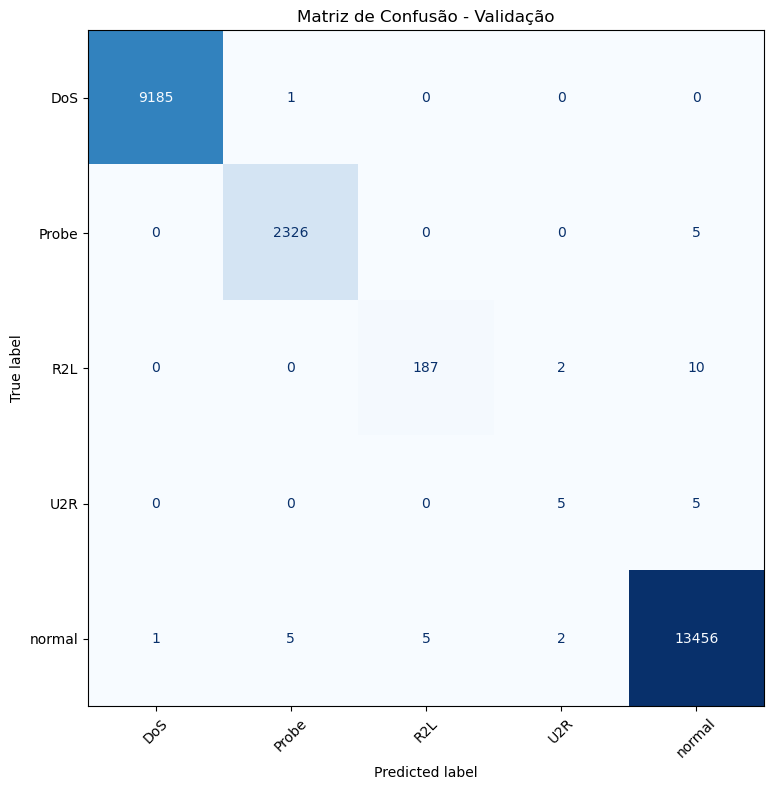

In [13]:
labels = sorted(y_val.unique())
cm = confusion_matrix(y_val, y_pred, labels=labels)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", xticks_rotation=45, ax=ax, colorbar=False)
plt.title("Matriz de Confusão - Validação")
plt.grid(False)
plt.tight_layout()
plt.show()

==== Relatório Binário (normal vs attack) ====
              precision    recall  f1-score   support

      normal     0.9985    0.9990    0.9988     13469
      attack     0.9989    0.9983    0.9986     11726

    accuracy                         0.9987     25195
   macro avg     0.9987    0.9987    0.9987     25195
weighted avg     0.9987    0.9987    0.9987     25195



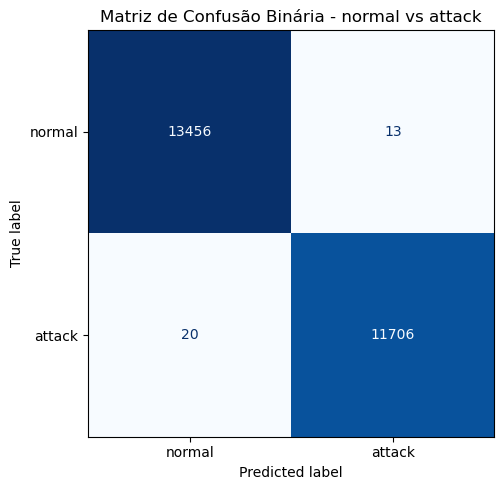

In [14]:
# Gera rótulos binários: 0 = normal, 1 = ataque
y_val_bin = y_val.apply(lambda x: 0 if x == "normal" else 1)
y_pred_bin = pd.Series(y_pred, index=y_val.index).apply(lambda x: 0 if x == "normal" else 1)

print("==== Relatório Binário (normal vs attack) ====")
print(classification_report(y_val_bin, y_pred_bin, target_names=["normal", "attack"], digits=4))

cm_bin = confusion_matrix(y_val_bin, y_pred_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bin, display_labels=["normal", "attack"])

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Blues", ax=ax, colorbar=False)
plt.title("Matriz de Confusão Binária - normal vs attack")
plt.grid(False)
plt.tight_layout()
plt.show()



### Avaliação no Conjunto de Teste Real (KDDTest+)

Agora, o modelo final, treinado com todos os dados de treino e os melhores hiperparâmetros, é avaliado no conjunto de teste real (`KDDTest+`). Este conjunto contém classes inéditas e distribuição diferente, permitindo analisar a capacidade de generalização do modelo para cenários do mundo real.

#### Avaliação com KDDTest+ (Conjunto de Teste Real)

O modelo final, treinado com todos os dados de treino e os melhores hiperparâmetros, é avaliado no conjunto de teste real (`KDDTest+`). Este conjunto contém classes inéditas e distribuição diferente, permitindo analisar a capacidade de generalização do modelo.

In [14]:
best_model = RandomForestClassifier(
    n_estimators=400,
    max_depth=30,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=10,
    class_weight='balanced',
    bootstrap=False,
    min_impurity_decrease=0.0,
    random_state=1,
    n_jobs=-1
)


best_model.fit(X_train_final, y_train_final)
y_pred = best_model.predict(X_test_final)

In [15]:
# Codificação para métricas numéricas
le = LabelEncoder()
y_test_enc = le.fit_transform(y_test_final)
y_pred_enc = le.transform(y_pred)
y_proba = best_model.predict_proba(X_test_final)

# Métricas principais
accuracy = accuracy_score(y_test_final, y_pred)
precision = precision_score(y_test_final, y_pred, average='macro')
recall = recall_score(y_test_final, y_pred, average='macro')
f1 = f1_score(y_test_final, y_pred, average='macro')
rmse = np.sqrt(mean_squared_error(y_test_enc, y_pred_enc))

# Confusion matrix para FPR e FNR
cm = confusion_matrix(y_test_enc, y_pred_enc)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

fpr = np.mean(FP / (FP + TN + 1e-10))
fnr = np.mean(FN / (FN + TP + 1e-10))

# AUC
try:
    auc = roc_auc_score(y_test_enc, y_proba, multi_class='ovr', average='macro')
except:
    auc = None

# Impressão final
print("==== Avaliação Global ====")
print(f"Acurácia:         {accuracy:.4f}")
print(f"Precisão:         {precision:.4f}")
print(f"Recall (TPR):     {recall:.4f}")
print(f"F1-Score:         {f1:.4f}")
print(f"FPR (média):      {fpr:.4f}")
print(f"FNR (média):      {fnr:.4f}")
print(f"RMSE:             {rmse:.4f}")
print(f"AUC (ROC):        {auc:.4f}" if auc is not None else "AUC (ROC):        Não aplicável")

==== Avaliação Global ====
Acurácia:         0.7193
Precisão:         0.6594
Recall (TPR):     0.4372
F1-Score:         0.4421
FPR (média):      0.0965
FNR (média):      0.5628
RMSE:             1.5333
AUC (ROC):        0.8972


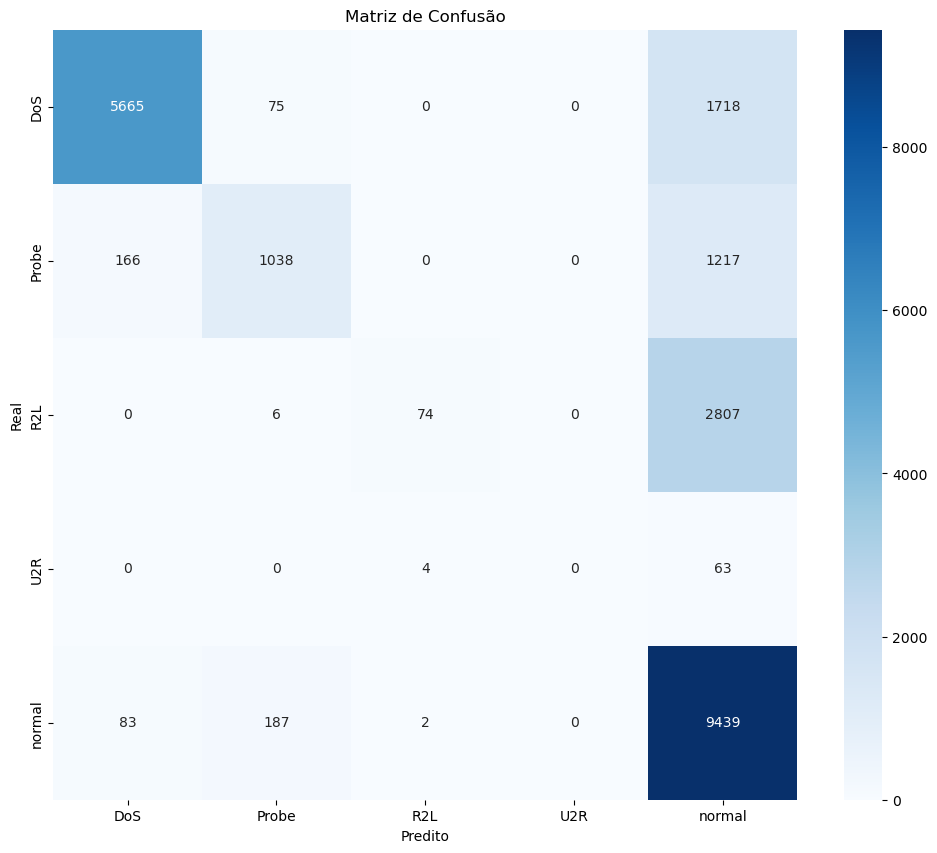

In [20]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

In [19]:
report = classification_report(y_test_final, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()


print(report_df)

              precision    recall  f1-score       support
DoS            0.957897  0.759587  0.847293   7458.000000
Probe          0.794793  0.428748  0.557016   2421.000000
R2L            0.925000  0.025632  0.049882   2887.000000
U2R            0.000000  0.000000  0.000000     67.000000
normal         0.619194  0.971991  0.756482   9711.000000
accuracy       0.719304  0.719304  0.719304      0.719304
macro avg      0.659377  0.437192  0.442135  22544.000000
weighted avg   0.787423  0.719304  0.672367  22544.000000
